# Фаза 1: Подготовка данных и Пространственный Инжиниринг

In [3]:
# --- 1.1 Установка и импорт библиотек ---
!pip install haversine tqdm -q
import pandas as pd
import numpy as np
import os
from google.colab import drive
from haversine import haversine, Unit
from tqdm.notebook import tqdm

# --- 1.2 Настройка и загрузка данных ---
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Ошибка при подключении Google Drive: {e}")

# --- ВАЖНО: Укажите ваш путь к файлу! ---Kabdygali
raw_data_path = "/content/drive/MyDrive/Decentrathon 4.0_inDrive Case 2_solution with VAE/geo_locations_astana_hackathon.csv"
output_dir = "/content/drive/MyDrive/Decentrathon 4.0_inDrive Case 2_solution with VAE/processed_data/"
os.makedirs(output_dir, exist_ok=True)

# --- 1.3 Очистка данных и сохранение ---
print("--- Шаг 1.3: Очистка данных ---")
df = pd.read_csv(raw_data_path)
print(f"Исходный размер: {len(df)} строк.")
df_cleaned = df[df['spd'] >= 0].copy()
df_cleaned = df_cleaned[(df_cleaned['alt'] >= 300) & (df_cleaned['alt'] <= 450)]
print(f"Размер после очистки: {len(df_cleaned)} строк.")

cleaned_path = os.path.join(output_dir, 'geotracks_cleaned.parquet')
df_cleaned.to_parquet(cleaned_path, index=False)
print(f"✅ Очищенные данные со всеми точками сохранены в: {cleaned_path}\n")


# --- 1.4 Пространственный инжиниринг ---
print("--- Шаг 1.4: Вычисление пространственных признаков ---")
df_features = df_cleaned.sort_values(by=['randomized_id']).copy()
df_features[['lat_prev', 'lng_prev']] = df_features.groupby('randomized_id')[['lat', 'lng']].shift(1)
df_features.dropna(subset=['lat_prev', 'lng_prev'], inplace=True)

# Векторизованный расчет расстояний
points1 = df_features[['lat_prev', 'lng_prev']].to_numpy()
points2 = df_features[['lat', 'lng']].to_numpy()
distances = [haversine(p1, p2, unit=Unit.METERS) for p1, p2 in tqdm(zip(points1, points2), total=len(points1), desc="Расчет расстояний")]
df_features['distance_m'] = distances

# Фильтрация коротких сегментов для стабильности расчетов
df_features = df_features[df_features['distance_m'] > 1.0].copy()

# Расчет пространственных производных (изменение на 100 метров)
df_features['d_speed_change'] = (df_features.groupby('randomized_id')['spd'].diff().fillna(0).abs() / df_features['distance_m']) * 100
df_features['d_turn_rate'] = (df_features.groupby('randomized_id')['azm'].diff().fillna(0).abs() / df_features['distance_m']) * 100
df_features['d_alt_grad'] = (df_features.groupby('randomized_id')['alt'].diff().fillna(0).abs() / df_features['distance_m']) * 100
print("✅ Пространственные признаки рассчитаны.\n")

# --- 1.5 Агрегация "ДНК" ---
print("--- Шаг 1.5: Агрегация признаков для каждой поездки ---")
agg_funcs = {
    'd_speed_change': ['mean', 'std', 'max', lambda x: x.quantile(0.95)],
    'd_turn_rate': ['mean', 'std', 'max', lambda x: x.quantile(0.95)],
    'd_alt_grad': ['mean', 'max', lambda x: x.quantile(0.95)],
    'spd': ['mean', 'std']
}
df_aggregated = df_features.groupby('randomized_id').agg(agg_funcs).fillna(0)
df_aggregated.columns = ['_'.join(col).strip().replace('<lambda_0>', 'q95') for col in df_aggregated.columns.values]

# Расчет извилистости
total_dist = df_features.groupby('randomized_id')['distance_m'].sum().rename('total_dist')
start_points = df_cleaned.groupby('randomized_id').first()
end_points = df_cleaned.groupby('randomized_id').last()
direct_dist_list = [haversine((s.lat, s.lng), (e.lat, e.lng), unit=Unit.METERS) for s, e in zip(start_points.itertuples(), end_points.itertuples())]
direct_dist = pd.Series(direct_dist_list, index=start_points.index, name='direct_dist')

df_aggregated = df_aggregated.join(total_dist, how='left').join(direct_dist, how='left')
df_aggregated['tortuosity'] = (df_aggregated['total_dist'] / (df_aggregated['direct_dist'] + 1e-6)).fillna(1)
df_aggregated.drop(columns=['total_dist', 'direct_dist'], inplace=True)

features_path = os.path.join(output_dir, 'features_spatial.parquet')
df_aggregated.to_parquet(features_path)
print(f"✅ Агрегированная 'ДНК' (матрица признаков) сохранена в: {features_path}")
print("\n======================= ФАЗА 1 ЗАВЕРШЕНА =======================")


Mounted at /content/drive
--- Шаг 1.3: Очистка данных ---
Исходный размер: 1262687 строк.
Размер после очистки: 1244607 строк.
✅ Очищенные данные со всеми точками сохранены в: /content/drive/MyDrive/Decentrathon 4.0_inDrive Case 2_solution with VAE/processed_data/geotracks_cleaned.parquet

--- Шаг 1.4: Вычисление пространственных признаков ---


Расчет расстояний:   0%|          | 0/1237926 [00:00<?, ?it/s]

✅ Пространственные признаки рассчитаны.

--- Шаг 1.5: Агрегация признаков для каждой поездки ---
✅ Агрегированная 'ДНК' (матрица признаков) сохранена в: /content/drive/MyDrive/Decentrathon 4.0_inDrive Case 2_solution with VAE/processed_data/features_spatial.parquet

======================= ФАЗА 1 ЗАВЕРШЕНА =======================


# Фаза 2: ML-Анализ "ДНК" (Variational Autoencoder)

Матрица признаков из Фазы 1 загружена.
Данные отмасштабированы, scaler сохранен.

Начинаем обучение β-VAE (β=4.0) на устройстве: cpu...


Обучение VAE:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Обучение VAE завершено.
✅ Анализ на основе VAE выполнен.

Оценка качества кластеризации:
  - VAE Silhouette Score: 0.693
  - VAE Calinski-Harabasz Score: 5453


============================== Визуализация графиков и анализ ==============================


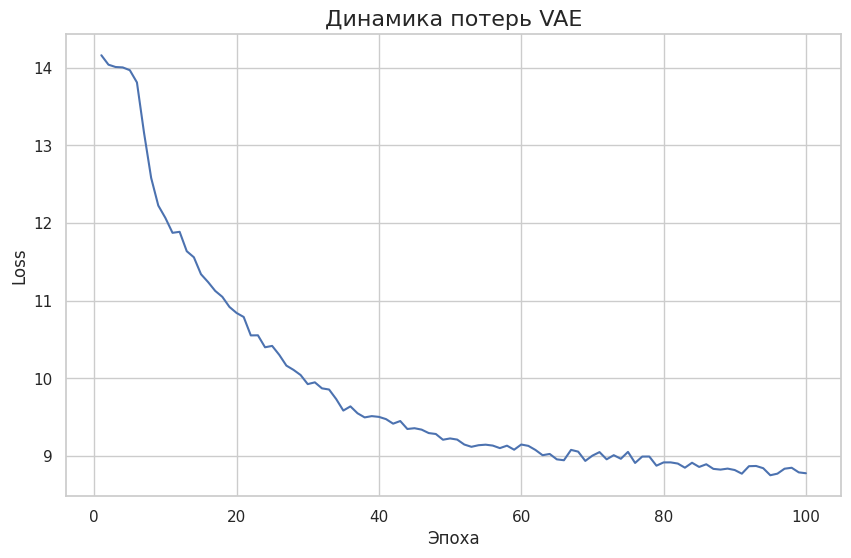

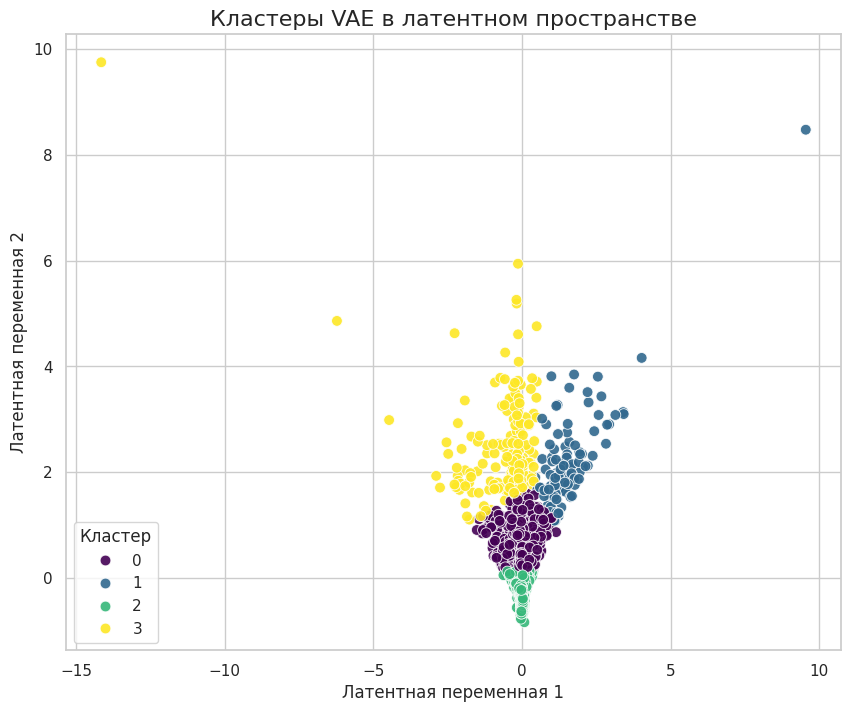

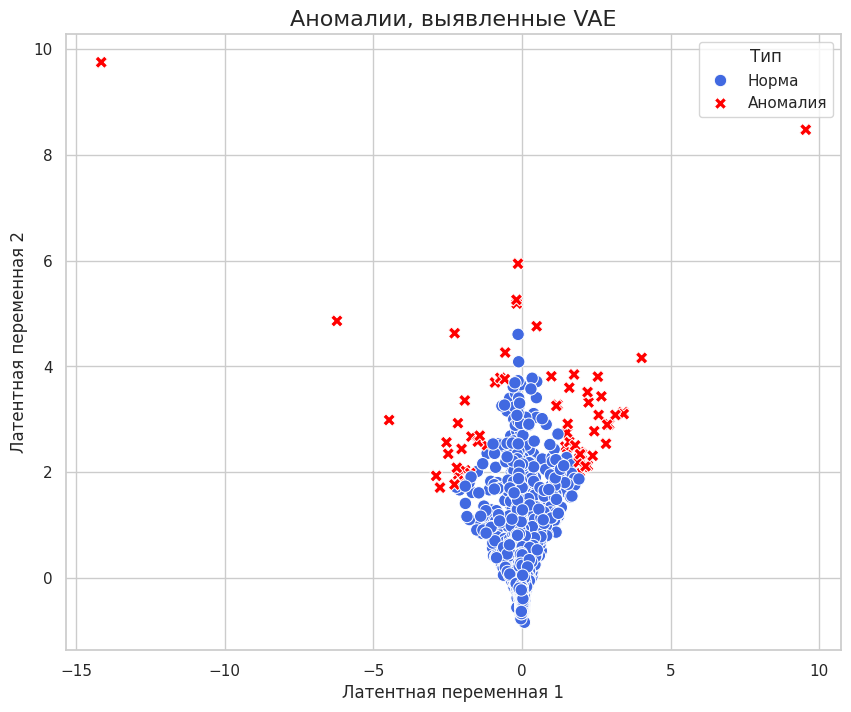


Профилирование кластеров...


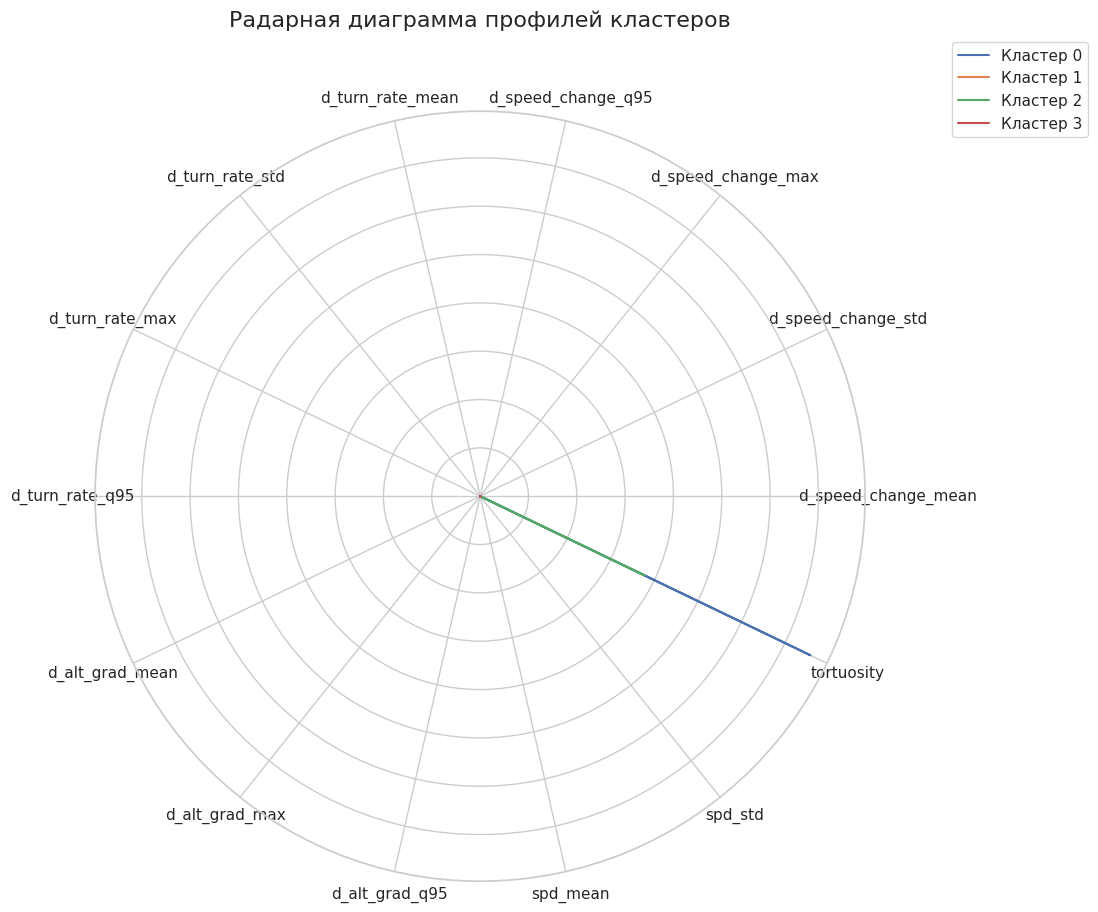


Топ-10 аномалий (чем ниже score, тем более аномальный объект):
      d_speed_change_mean  d_speed_change_std  d_speed_change_max  \
2320                8.645              13.528              35.697   
5262              176.622             468.301            1849.146   
517                91.150             193.203             484.830   
1073                1.942               5.817              40.064   
3338                3.575               4.767              12.022   
3366               33.345              76.214             221.176   
1814                0.759               0.710               1.407   
6109                5.656               6.873              19.067   
4733                6.027               6.994              28.166   
3648               13.188              18.650              26.376   

      d_speed_change_q95  d_turn_rate_mean  d_turn_rate_std  d_turn_rate_max  \
2320              35.697          2302.311         3970.356         9639.552   
5262            

In [4]:
# --- 2.1 Установка и импорт библиотек ---
# Убрали plotly и kaleido, добавили matplotlib и seaborn
!pip install umap-learn pandas torch scikit-learn matplotlib seaborn joblib tqdm -q

import pandas as pd
import numpy as np
import os
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from tqdm.notebook import tqdm

# --- НОВЫЕ ИМПОРТЫ ДЛЯ ВИЗУАЛИЗАЦИИ ---
import matplotlib.pyplot as plt
import seaborn as sns

# Устанавливаем стиль для графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# --- 2.2 Загрузка данных из Фазы 1 ---
try:
    # !!! ВАЖНО: Укажите здесь свой правильный путь к папке
    output_dir = "/content/drive/MyDrive/Decentrathon 4.0_inDrive Case 2_solution with VAE/processed_data/"
    features_path = os.path.join(output_dir, 'features_spatial.parquet')
    os.makedirs(output_dir, exist_ok=True)

    # Попытка загрузить ваш файл
    df_features = pd.read_parquet(features_path)
    print("Матрица признаков из Фазы 1 загружена.")

except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    # Если файл не найден, для демонстрации создается случайный DataFrame
    print("ВНИМАНИЕ: Создаю демонстрационный DataFrame, т.к. файл не найден.")
    output_dir = "./temp_data/"
    os.makedirs(output_dir, exist_ok=True)
    df_features = pd.DataFrame(np.random.rand(1000, 15), columns=[f'feature_{i}' for i in range(15)])
    df_features.index.name = 'object_id'


if df_features is not None:
    # --- 2.3 Масштабирование данных ---
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_features)
    features_tensor = torch.FloatTensor(features_scaled)
    joblib.dump(scaler, os.path.join(output_dir, 'dna_scaler.gz'))
    print("Данные отмасштабированы, scaler сохранен.")

    # --- 2.4 Определение VAE с УЛУЧШЕННОЙ архитектурой ---
    class VAE(nn.Module):
        def __init__(self, input_dim, latent_dim=2):
            super(VAE, self).__init__()
            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.LeakyReLU(0.1),
                nn.Linear(128, 64),
                nn.LeakyReLU(0.1)
            )
            self.fc_mu = nn.Linear(64, latent_dim)
            self.fc_log_var = nn.Linear(64, latent_dim)

            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 64),
                nn.LeakyReLU(0.1),
                nn.Linear(64, 128),
                nn.LeakyReLU(0.1),
                nn.Linear(128, input_dim)
            )

        def reparameterize(self, mu, log_var):
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std

        def forward(self, x):
            h = self.encoder(x)
            mu, log_var = self.fc_mu(h), self.fc_log_var(h)
            z = self.reparameterize(mu, log_var)
            return self.decoder(z), mu, log_var

    def vae_loss_function(recon_x, x, mu, log_var, beta=1.0):
        MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return MSE + beta * KLD

    # --- Обучение УЛУЧШЕННОЙ модели ---
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = VAE(input_dim=features_scaled.shape[1], latent_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    dataloader = DataLoader(TensorDataset(features_tensor), batch_size=32, shuffle=True)

    BETA = 4.0
    EPOCHS = 100

    print(f"\nНачинаем обучение β-VAE (β={BETA}) на устройстве: {device}...")
    epoch_losses = []
    for epoch in tqdm(range(EPOCHS), desc="Обучение VAE"):
        epoch_loss = 0.0
        for data in dataloader:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            recon, mu, log_var = model(inputs)
            loss = vae_loss_function(recon, inputs, mu, log_var, beta=BETA)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader.dataset)
        epoch_losses.append(avg_epoch_loss)
    print("✅ Обучение VAE завершено.")

    # --- 2.5 Анализ результатов ---
    model.eval()
    with torch.no_grad():
        _, latent_vectors, _ = model(features_tensor.to(device))
        latent_vectors = latent_vectors.cpu().numpy()

    df_results = pd.DataFrame(index=df_features.index)
    df_results['latent_1'] = latent_vectors[:, 0]
    df_results['latent_2'] = latent_vectors[:, 1]
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df_results['cluster'] = kmeans.fit_predict(latent_vectors)
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    df_results['is_anomaly'] = np.where(iso_forest.fit_predict(latent_vectors) == -1, 1, 0)
    df_results['anomaly_score'] = iso_forest.decision_function(latent_vectors)
    print("✅ Анализ на основе VAE выполнен.")

    # --- 2.6 Оценка качества ---
    silhouette = silhouette_score(latent_vectors, df_results['cluster'])
    calinski = calinski_harabasz_score(latent_vectors, df_results['cluster'])
    print(f"\nОценка качества кластеризации:")
    print(f"  - VAE Silhouette Score: {silhouette:.3f}")
    print(f"  - VAE Calinski-Harabasz Score: {calinski:.0f}\n")

    # --- 2.7 Визуализация и анализ с помощью Matplotlib ---
    print("\n" + "="*30 + " Визуализация графиков и анализ " + "="*30)

    # 1. График потерь
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), epoch_losses)
    plt.title("Динамика потерь VAE", fontsize=16)
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.show()

    # 2. Визуализация кластеров
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='latent_1', y='latent_2', hue='cluster', data=df_results,
        palette='viridis', s=60, alpha=0.9
    )
    plt.title('Кластеры VAE в латентном пространстве', fontsize=16)
    plt.xlabel('Латентная переменная 1')
    plt.ylabel('Латентная переменная 2')
    plt.legend(title='Кластер')
    plt.show()

    # 3. Визуализация аномалий
    df_results['anomaly_label'] = df_results['is_anomaly'].map({0: 'Норма', 1: 'Аномалия'})
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='latent_1', y='latent_2', hue='anomaly_label', style='anomaly_label',
        markers={'Норма': 'o', 'Аномалия': 'X'},
        palette={'Норма': 'royalblue', 'Аномалия': 'red'},
        s=80, data=df_results
    )
    plt.title('Аномалии, выявленные VAE', fontsize=16)
    plt.xlabel('Латентная переменная 1')
    plt.ylabel('Латентная переменная 2')
    plt.legend(title='Тип')
    plt.show()

    # 4. Профилирование кластеров и радарная диаграмма
    print("\nПрофилирование кластеров...")
    df_analysis = pd.concat([df_features.reset_index(drop=True), df_results.reset_index(drop=True)], axis=1)
    cluster_profiles = df_analysis.groupby('cluster')[df_features.columns].mean()

    # --- Код для радарной диаграммы на Matplotlib ---
    labels = cluster_profiles.columns
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i, row in cluster_profiles.iterrows():
        values = row.values.tolist()
        values += values[:1]
        ax.plot(angles, values, label=f"Кластер {i}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title("Радарная диаграмма профилей кластеров", size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

    # 5. Анализ топ-аномалий
    top_anomalies = df_analysis[df_analysis['is_anomaly'] == 1].sort_values(by='anomaly_score').head(10)
    print("\nТоп-10 аномалий (чем ниже score, тем более аномальный объект):")
    print(top_anomalies[list(df_features.columns) + ['anomaly_score']].round(3))

    # --- 2.8 Сохранение результатов ---
    model_path = os.path.join(output_dir, 'vae_model.pt')
    results_path = os.path.join(output_dir, 'dna_results_vae.parquet')
    torch.save(model.state_dict(), model_path)
    df_results.to_parquet(results_path)
    print(f"\n✅ Обученная модель VAE сохранена в: {model_path}")
    print(f"✅ Результаты анализа VAE сохранены в: {results_path}")
    print("\n======================= ФАЗА 2 ЗАВЕРШЕНА =======================")

In [5]:
!pip install plotly


In [6]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(
    x=list(range(1, EPOCHS + 1)),
    y=epoch_losses,
    labels={'x': 'Эпоха', 'y': 'Loss'},
    title="Динамика потерь VAE"
)
fig.show()


In [7]:
fig = px.scatter(
    df_results, x='latent_1', y='latent_2',
    color='cluster',
    title='Кластеры VAE в латентном пространстве',
    symbol='cluster',
    size_max=10,
    hover_data=df_results.columns
)
fig.show()


In [8]:
fig = px.scatter(
    df_results, x='latent_1', y='latent_2',
    color='anomaly_label',
    symbol='anomaly_label',
    title='Аномалии, выявленные VAE',
    hover_data=df_results.columns
)
fig.show()


In [12]:
print(cluster_profiles)

         d_speed_change_mean  d_speed_change_std  d_speed_change_max  \
cluster                                                                
0                   4.059607            8.860857           81.158485   
1                   4.009744            7.247944           59.834771   
2                   2.422418            4.642362           36.726853   
3                  10.975081           20.516742          113.791220   

         d_speed_change_q95  d_turn_rate_mean  d_turn_rate_std  \
cluster                                                          
0                 14.110527        302.314711      1135.366446   
1                 14.142780        789.186367      1685.656439   
2                  8.775702         52.060978       185.240828   
3                 38.696391       1976.834931      3464.624815   

         d_turn_rate_max  d_turn_rate_q95  d_alt_grad_mean  d_alt_grad_max  \
cluster                                                                      
0           11

In [13]:
from sklearn.preprocessing import MinMaxScaler

# 1. Нормализация профилей кластеров
scaler = MinMaxScaler()  # или StandardScaler()
cluster_profiles_norm = pd.DataFrame(
    scaler.fit_transform(cluster_profiles),
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# 2. Рисуем radar chart по нормализованным профилям
labels = list(cluster_profiles_norm.columns)
labels += labels[:1]  # замкнуть круг

import plotly.graph_objects as go
fig = go.Figure()
for i, row in cluster_profiles_norm.iterrows():
    values = list(row.values)
    values += values[:1]
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=labels,
        fill='toself',
        name=f'Кластер {i}',
        mode='lines+markers',
        opacity=0.7
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),  # шкала 0..1
    showlegend=True,
    title="Радарная диаграмма нормализованных профилей кластеров"
)
fig.show()
